# IMPORT AND CONFIGURATIONS

In [1]:
# ==========================================
# 0. IMPORTING
# ==========================================
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
import folium
from shapely.geometry import box
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ipywidgets import interact, SelectionSlider
from matplotlib.lines import Line2D
from folium.plugins import MarkerCluster

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

warnings.filterwarnings("ignore")


In [2]:
# ==========================================
# 1. CONFIGURATION
# ==========================================

CITY_CONFIG = {
    "name": "Roma",
    "region": "Lazio",
    "country_code": "ITA",
}

'''
CITY_CONFIG = {
    "name": "Napoli",
    "region": "Campania",
    "country_code": "ITA",
}

CITY_CONFIG = {
    "name": "Paris",
    "region": "Île-de-France",
    "country_code": "FRA",
}

CITY_CONFIG = {
    "name": "Oslo",
    "region": "Oslo",
    "country_code": "NOR",
}

CITY_CONFIG = {
    "name": "Bergen",
    "region": "Hordaland",
    "country_code": "NOR",
}

CITY_CONFIG = {
    "name": "Tromsø",
    "region": "Troms",
    "country_code": "NOR",
}

CITY_CONFIG = {
    "name": "Amsterdam",
    "region": "Noord-Holland",
    "country_code": "NLD",
}

CITY_CONFIG = {
    "name": "Berlin",
    "region": "Berlin",
    "country_code": "DEU",
}
'''

CITY_CONFIG={
    "name": "Napoli",
    "region": "Campania",
    "country_code": "ITA",
}

DATA_FOLDER= "data/"
GADM_FILE_PATH = os.path.join(DATA_FOLDER, "gadm_410_europe.gpkg")
NDVI_FOLDER= os.path.join(DATA_FOLDER, "sentinel2_ndvi")
OUTPUT_DIR =os.path.join("output", CITY_CONFIG['name'])
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"--- Total NDVI Analysis on {CITY_CONFIG['name']} ---")

--- Total NDVI Analysis on Napoli ---


In [3]:
categories = [
        ("Urban", "#606060"),   # Dark Grey for high visibility
        ("Suburban", "#FFA500"),  # Orange
        ("Vegetation", "#00AA00") # Green
    ]

colors = {"Urban": "#404040", "Suburban": "#FFA500", "Vegetation": "#00AA00"}
color_map = {
    "Urban": "#808080",    # Grey
    "Suburban": "#FFA500",  # Orange
    "Vegetation": "#008000"  # Green
}

COLOR_MAP = {
    "Urban": "rgb(40, 40, 40)",       # Grigio scuro
    "Suburban": "rgb(255, 140, 0)",   # Arancione
    "Vegetation": "rgb(34, 139, 34)", # Verde
    "Water": "rgb(0, 0, 200)"         # Blu
}

color_map = {
    "Urban": "#808080",      # Grey
    "Suburban": "#FFA500",   # Orange
    "Vegetation": "#008000", # Green
    "Water": "#0000FF",      # Blue
    "Forest": "#008000"
}

In [4]:
# ==========================================
# 2. LOADING BOUNDARIES (To clip to the exact shape)
# ==========================================
print("1. Loading exact city geometry...")
gdf_europe =gpd.read_file(GADM_FILE_PATH)
gdf_city=gdf_europe[
    (gdf_europe['GID_0'] ==CITY_CONFIG["country_code"]) &
    (gdf_europe['NAME_1']== CITY_CONFIG["region"]) &
    (gdf_europe['NAME_2']==CITY_CONFIG["name"])
]
city_geom = gdf_city.union_all()

1. Loading exact city geometry...


In [5]:
# ==========================================
# 3. RASTER PROCESSING OVER THE ENTIRE AREA
# ==========================================
all_files = glob.glob(os.path.join(NDVI_FOLDER, "*.tif"))
summer_files = [f for f in all_files if "06-01" in f and "09-01" in f]

if not summer_files:
    raise ValueError("No summer files found.")

print(f"2. Processing {len(summer_files)} summer files over the entire surface...")

ndvi_arrays = []

ref_ds = rioxarray.open_rasterio(summer_files[0])
gdf_city_proj = gdf_city.to_crs(ref_ds.rio.crs)

for f in summer_files:
    try:
        ds = rioxarray.open_rasterio(f, masked=True)
        ds_clipped = ds.rio.clip(gdf_city_proj.geometry, drop=True)
        ndvi_arrays.append(ds_clipped)
    except Exception as e:
        print(f"   Error/Skip {os.path.basename(f)}: {e}")

combined=xr.concat(ndvi_arrays, dim="time")
mean_ndvi_raw= combined.mean(dim="time")
mean_ndvi = (mean_ndvi_raw / 255.0 * 2.0) - 1.0

2. Processing 4 summer files over the entire surface...


In [6]:
# ==========================================
# 4. WATER DATA INTEGRATION (JRC) AND GRID CREATION
# ==========================================
print("3. Integrating JRC Water Data and Converting to Polygons...")

centroid = gdf_city.to_crs("EPSG:4326").geometry.centroid.iloc[0]
cent_x, cent_y = centroid.x, centroid.y

tile_lon=int(np.floor(cent_x / 10) * 10)
tile_lat= int(np.ceil(cent_y / 10) * 10)

lon_str= f"{abs(tile_lon)}E" if tile_lon >= 0 else f"{abs(tile_lon)}W"
lat_str=f"{abs(tile_lat)}N" if tile_lat >=0 else f"{abs(tile_lat)}S"

filename_jrc=f"occurrence_{lon_str}_{lat_str}v1_4_2021.tif"
GSW_FILE_PATH=os.path.join("data_gswe", filename_jrc)

print(f" City centered at Lon: {cent_x:.2f}, Lat: {cent_y:.2f}")
print(f" Calculated JRC Tile: {filename_jrc}")

if os.path.exists(GSW_FILE_PATH):
    print(f" Loading water raster: {GSW_FILE_PATH}")
    jrc_ds=rioxarray.open_rasterio(GSW_FILE_PATH)
    
    bbox_wgs84 = gdf_city.to_crs("EPSG:4326").total_bounds
    try:
        jrc_clipped = jrc_ds.rio.clip_box(*bbox_wgs84)
        
        print("   Aligning water raster to NDVI grid (Reproject Match)...")
        jrc_aligned = jrc_clipped.rio.reproject_match(mean_ndvi, resampling=0)
        water_da = jrc_aligned[0]
        
    except Exception as e:
        print(f"   ERROR clipping JRC (perhaps the city is outside the downloaded tile?): {e}")
        print(" Proceeding assuming 0% water.")
        water_da = xr.zeros_like(mean_ndvi)
else:
    print(f" WARNING: JRC File {filename_jrc} not found in data_gswe/.")
    print(f"  Make sure you downloaded tile {lon_str}_{lat_str} from the GSW site.")
    print(" Proceeding assuming 0% water.")
    water_da = xr.zeros_like(mean_ndvi)

ds_combined =xr.Dataset({
    'ndvi': mean_ndvi,
    'water': water_da
})
df_pixel= ds_combined.to_dataframe().reset_index()
df_pixel =df_pixel.dropna(subset=['ndvi'])
res_x =float(mean_ndvi.rio.transform().a)
res_y = float(mean_ndvi.rio.transform().e)

print(f" Total raw pixels found: {len(df_pixel)}")

MAX_POLYGONS = 175000
if len(df_pixel) > MAX_POLYGONS:
    step =int(np.ceil(len(df_pixel) / MAX_POLYGONS))
    print(f"   WARNING: {len(df_pixel)} is too many for the browser. Sampling 1 every {step}.")
    df_pixel_viz = df_pixel.iloc[::step].copy()
else:
    df_pixel_viz = df_pixel.copy()

def create_pixel_polygon(row):
    half_x=abs(res_x) / 2
    half_y= abs(res_y) / 2
    return box(row['x'] - half_x, row['y'] - half_y, row['x'] + half_x, row['y'] + half_y)

df_pixel_viz['geometry'] = df_pixel_viz.apply(create_pixel_polygon, axis=1)
gdf_grid = gpd.GeoDataFrame(df_pixel_viz, geometry='geometry', crs=mean_ndvi.rio.crs)
gdf_grid = gdf_grid.to_crs("EPSG:4326")

3. Integrating JRC Water Data and Converting to Polygons...
 City centered at Lon: 14.39, Lat: 40.97
 Calculated JRC Tile: occurrence_10E_50Nv1_4_2021.tif
 Loading water raster: data_gswe\occurrence_10E_50Nv1_4_2021.tif
   Aligning water raster to NDVI grid (Reproject Match)...
 Total raw pixels found: 185607


In [7]:
# ==========================================
# 5. CLASSIFICATION AND MAP
# ==========================================
print("4. Classification and Map Generation...")

def classify_pixel(row):
    ndvi_val = row['ndvi']
    water_val = row['water'] 

    if water_val > 10: 
        return "Water", "#0000FF"
    
    if ndvi_val <= 0.33  : # good 33
        return "Urban", "#2B2B2B"
        
    elif ndvi_val <= 0.60: 
        return "Park/grassland", "#FFA500"
        
    else: 
        return "Forest", "#008000"

gdf_grid[['class_label', 'color']] =gdf_grid.apply(lambda row: pd.Series(classify_pixel(row)), axis=1)

center_lat=gdf_grid.geometry.centroid.y.mean()
center_lon= gdf_grid.geometry.centroid.x.mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles="CartoDB positron")

def style_function(feature):
    return {
        "fillColor": feature['properties']['color'],
        "color": "black", "weight": 0.5, "fillOpacity": 0.7,
    }
    
def highlight_function(feature):
    return {
        "fillColor": feature['properties']['color'],
        "color": "white", "weight": 2, "fillOpacity": 0.9,
    }

folium.GeoJson(
    gdf_grid,
    name="NDVI Grid",
    style_function=style_function,
    highlight_function=highlight_function,
    tooltip=folium.GeoJsonTooltip(fields=['class_label', 'ndvi'], aliases=['Type:', 'NDVI:'], localize=True),
    popup=folium.GeoJsonPopup(fields=['class_label', 'ndvi'], aliases=['Type:', 'NDVI:'])
).add_to(m)

folium.GeoJson(
    city_geom, 
    name="Administrative Boundary",
    style_function=lambda x: {"fillColor": "none", "color": "red", "weight": 2}
).add_to(m)

folium.LayerControl().add_to(m)

output_filename = f"map_FULL_{CITY_CONFIG['name']}_Interactive.html"
output_html = os.path.join(OUTPUT_DIR, output_filename)

m.save(output_html)
print(f" Map saved in: {output_html}")

4. Classification and Map Generation...
 Map saved in: output\Napoli\map_FULL_Napoli_Interactive.html


In [8]:
# ==========================================
# 6. PIXEL AGGREGATION (80x80m) INTO 9km x 9km CELLS
# ==========================================
crs_metrico=mean_ndvi.rio.crs
gdf_small_m= gdf_grid.to_crs(crs_metrico)
city_geom_m= gdf_city_proj.unary_union

cell_size =9000.0 
minx, miny, maxx, maxy = gdf_small_m.total_bounds
big_polys, big_ids = [], []

row_id = 0
y = miny
while y < maxy:
    x =minx
    col_id =0
    while x <maxx:
        poly =box(x, y, x + cell_size, y + cell_size)
        if poly.intersects(city_geom_m):
            big_polys.append(poly)
            big_ids.append(f"cell_{row_id}_{col_id}")
        x += cell_size
        col_id += 1
    y += cell_size
    row_id += 1

gdf_big =gpd.GeoDataFrame({"cell_id": big_ids}, geometry=big_polys, crs=crs_metrico)
print(f"9km x 9km cells created: {len(gdf_big)}")

joined =gpd.sjoin(
    gdf_small_m[['class_label', 'geometry']],
    gdf_big[['cell_id', 'geometry']],
    how='inner', predicate='intersects'
)
print(f"  Pixels assigned to macro-cells: {len(joined)}")

counts =joined.groupby(['cell_id', 'class_label']).size().reset_index(name='n_cells')
totals= counts.groupby('cell_id')['n_cells'].sum().reset_index(name='n_total')
stats=counts.merge(totals, on='cell_id')
stats['perc'] = (stats['n_cells'] / stats['n_total']) * 100.0

pivot=stats.pivot(index='cell_id', columns='class_label', values='perc').fillna(0.0).reset_index()

for cls in ['Water', 'Forest', 'Urban', 'Park/grassland']:
    if cls not in pivot.columns:
        pivot[cls] =0.0

pivot = pivot.rename(columns={
    'Water': 'perc_water', 'Forest': 'perc_forest',
    'Urban': 'perc_urban', 'Park/grassland': 'perc_park'
})

def classify_macro(row):
    p_nature = row['perc_water'] + row['perc_park']
    
    if p_nature > 70.0: 
        return "Vegetation", "#008000" 
    
    else:
        if row['perc_forest'] > row['perc_urban'] and row['perc_forest'] > 30:
            return "Vegetation", "#008000"            
        elif row['perc_urban'] >= p_nature or row['perc_urban'] > 40 :
            return "Urban", "#808080" 
            
        else:
            return "Suburban", "#FFA500"   

pivot[['macro_label', 'macro_color']] = pivot.apply(lambda r: pd.Series(classify_macro(r)), axis=1)

gdf_big_stats =gdf_big.merge(pivot, on='cell_id', how='inner')

cols_to_round =['perc_water', 'perc_forest', 'perc_urban', 'perc_park']

for col in cols_to_round:
    if col in gdf_big_stats.columns:
        gdf_big_stats[col] = gdf_big_stats[col].round(1)

gdf_big_wgs84 = gdf_big_stats.to_crs("EPSG:4326")

m_big = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles="CartoDB positron")

folium.GeoJson(
    gdf_big_wgs84,
    name="9km Macro-grid",
    style_function=lambda x: {
        "fillColor": x["properties"]["macro_color"], 
        "color": "black", 
        "weight": 1, 
        "fillOpacity": 0.7
    },
    tooltip=folium.GeoJsonTooltip(fields=["macro_label"], aliases=["Macro Class:"]),
    popup=folium.GeoJsonPopup(
        fields=["macro_label", "perc_water", "perc_forest", "perc_park", "perc_urban"],
        aliases=["Label", "Water %", "Forest %", "Park %", "Urban %"]
    )
).add_to(m_big)

folium.GeoJson(
    gdf_city.to_crs("EPSG:4326"), 
    name="Administrative Boundary",
    style_function=lambda x: {"fillColor": "none", "color": "red", "weight": 2}
).add_to(m_big)

folium.LayerControl().add_to(m_big)

output_html_big = os.path.join(OUTPUT_DIR, "map_MACRO_9km_Interactive.html")
m_big.save(output_html_big)
print(f"New macro-grid map saved in: {output_html_big}")

9km x 9km cells created: 35
  Pixels assigned to macro-cells: 94476
New macro-grid map saved in: output\Napoli\map_MACRO_9km_Interactive.html


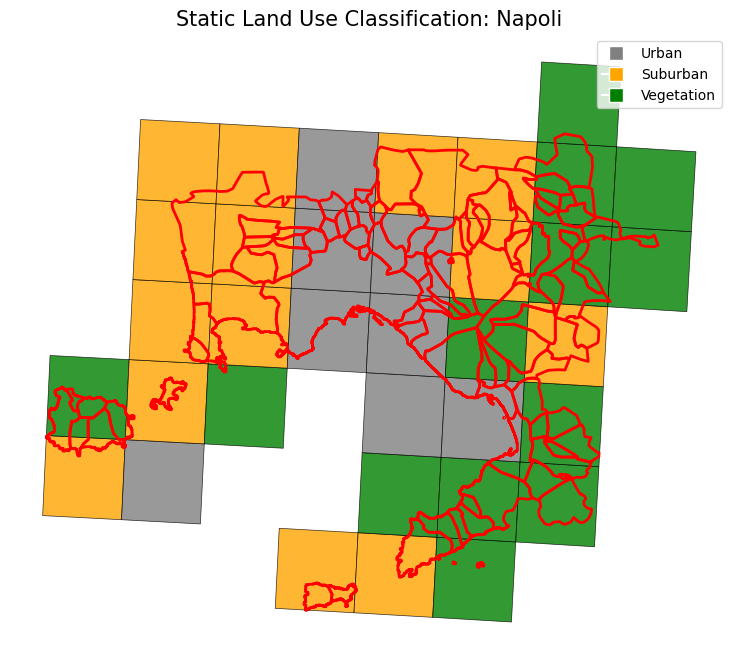

  Precipitation loaded.
  Wind loaded.
  Temperature loaded.


interactive(children=(SelectionSlider(continuous_update=False, description='Date:', index=2068, layout=Layout(…

In [9]:
# ==========================================
# 7. VISUALIZATION: STATIC LAND USE & INTERACTIVE CLIMATE DASHBOARD
# ==========================================

fig_lu, ax_lu = plt.subplots(figsize=(10, 8))

gdf_big_wgs84['plot_color'] = gdf_big_wgs84['macro_label'].map(color_map).fillna("lightgrey")

gdf_big_wgs84.plot(
    ax=ax_lu, 
    color=gdf_big_wgs84['plot_color'], 
    edgecolor='black', 
    linewidth=0.5,
    alpha=0.8
)
gdf_city.to_crs("EPSG:4326").plot(ax=ax_lu, facecolor="none", edgecolor="red", linewidth=2)

legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#808080', markersize=10, label='Urban'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#FFA500', markersize=10, label='Suburban'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='#008000', markersize=10, label='Vegetation')
]
ax_lu.legend(handles=legend_elements, loc='upper right')
ax_lu.set_title(f"Static Land Use Classification: {CITY_CONFIG['name']}", fontsize=15)
ax_lu.set_axis_off()
plt.show()


ERA5_FOLDER = os.path.join("data", "derived-era5-land-daily-statistics")

pat_precip = os.path.join(ERA5_FOLDER, "*_total_precipitation_daily_mean.nc")
pat_wind = os.path.join(ERA5_FOLDER, "*_component_of_wind_daily_mean.nc")
pat_temp = os.path.join(ERA5_FOLDER, "*_2m_temperature_daily_maximum.nc")

def load_era5_var(pattern, name):
    try:
        ds = xr.open_mfdataset(pattern, combine='by_coords')
        if 'valid_time' in ds.coords:
            ds = ds.rename({'valid_time': 'time'})
        print(f"  {name} loaded.")
        return ds
    except Exception as e:
        print(f"   ERROR loading {name}: {e}")
        return None

ds_precip = load_era5_var(pat_precip, "Precipitation")
ds_wind = load_era5_var(pat_wind, "Wind")
ds_temp = load_era5_var(pat_temp, "Temperature")

if ds_precip is not None:
    centroids = gdf_big_wgs84.geometry.centroid
    target_lons = xr.DataArray(centroids.x.values, dims="cell_id")
    target_lats = xr.DataArray(centroids.y.values, dims="cell_id")
    
    all_times = ds_precip['time'].values
    available_dates = pd.to_datetime(all_times).strftime('%Y-%m-%d').tolist()
    
    default_date = "2025-08-30"
    if default_date not in available_dates:
        if available_dates:
            default_date = available_dates[0]
        else:
            default_date = None
else:
    available_dates = ["Data Not Found"]
    default_date = "Data Not Found"

def update_dashboard(date_str):
    if ds_precip is None: 
        return

    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    
    def get_data_at_centroids(ds, var_name, date_s):
        try:
            subset = ds.sel(time=date_s, method='nearest')
            if var_name not in subset:
                var_name = list(subset.data_vars)[0]
                
            vals = subset[var_name].sel(longitude=target_lons, latitude=target_lats, method='nearest').values
            return vals
        except:
            return np.zeros(len(gdf_big_wgs84))

    ax1 = axs[0]
    vals_precip = get_data_at_centroids(ds_precip, 'tp', date_str)
    gdf_big_wgs84['val_precip'] = vals_precip * 1000.0 # m to mm
    
    gdf_big_wgs84.plot(ax=ax1, column='val_precip', cmap='Blues',
                       edgecolor='black', linewidth=0.5, vmin=0, vmax=20,
                       legend=True, legend_kwds={'label': "Precip (mm)", 'orientation': "horizontal", 'shrink': 0.8})
    gdf_city.to_crs("EPSG:4326").plot(ax=ax1, facecolor="none", edgecolor="red", linewidth=1.5)
    ax1.set_title(f"Precipitation (mm)", fontsize=14)
    ax1.set_axis_off()

    ax2 = axs[1]
    if ds_wind is not None:
        u_vals = get_data_at_centroids(ds_wind, 'u10', date_str)
        v_vals = get_data_at_centroids(ds_wind, 'v10', date_str)
        
        speed = np.sqrt(u_vals**2 + v_vals**2)
        gdf_big_wgs84['val_wind_speed'] = speed
        
        gdf_big_wgs84.plot(ax=ax2, column='val_wind_speed', cmap='Purples',
                           edgecolor='black', linewidth=0.5, vmin=0, vmax=10,
                           legend=True, legend_kwds={'label': "Wind Speed (m/s)", 'orientation': "horizontal", 'shrink': 0.8})
        
        ax2.quiver(centroids.x, centroids.y, u_vals, v_vals, color='black', alpha=0.6, scale=100)
    else:
        ax2.text(0.5, 0.5, "No Wind Data", ha='center')

    gdf_city.to_crs("EPSG:4326").plot(ax=ax2, facecolor="none", edgecolor="red", linewidth=1.5)
    ax2.set_title(f"Wind Speed & Direction", fontsize=14)
    ax2.set_axis_off()

    ax3 = axs[2]
    if ds_temp is not None:
        temp_vars = list(ds_temp.data_vars)
        t_var = 'mx2t' if 'mx2t' in temp_vars else temp_vars[0]
        
        vals_temp = get_data_at_centroids(ds_temp, t_var, date_str)
        
        vals_temp_c = vals_temp - 273.15
        gdf_big_wgs84['val_temp'] = vals_temp_c
        
        gdf_big_wgs84.plot(ax=ax3, column='val_temp', cmap='Spectral_r',
                           edgecolor='black', linewidth=0.5, vmin=0, vmax=40,
                           legend=True, legend_kwds={'label': "Temp Max (°C)", 'orientation': "horizontal", 'shrink': 0.8})
    else:
        ax3.text(0.5, 0.5, "No Temp Data", ha='center')

    gdf_city.to_crs("EPSG:4326").plot(ax=ax3, facecolor="none", edgecolor="red", linewidth=1.5)
    ax3.set_title(f"Max Temperature (°C)", fontsize=14)
    ax3.set_axis_off()

    #plt.suptitle(f"Weather Conditions: {date_str}", fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

if ds_precip is not None and default_date is not None:
    interact(
        update_dashboard, 
        date_str=SelectionSlider(
            options=available_dates,
            value=default_date,
            description='Date:',
            continuous_update=False, 
            layout={'width': '80%'}
        )
    )
else:
    print("Cannot launch dashboard: Missing Precipitation Data or Date Range.")

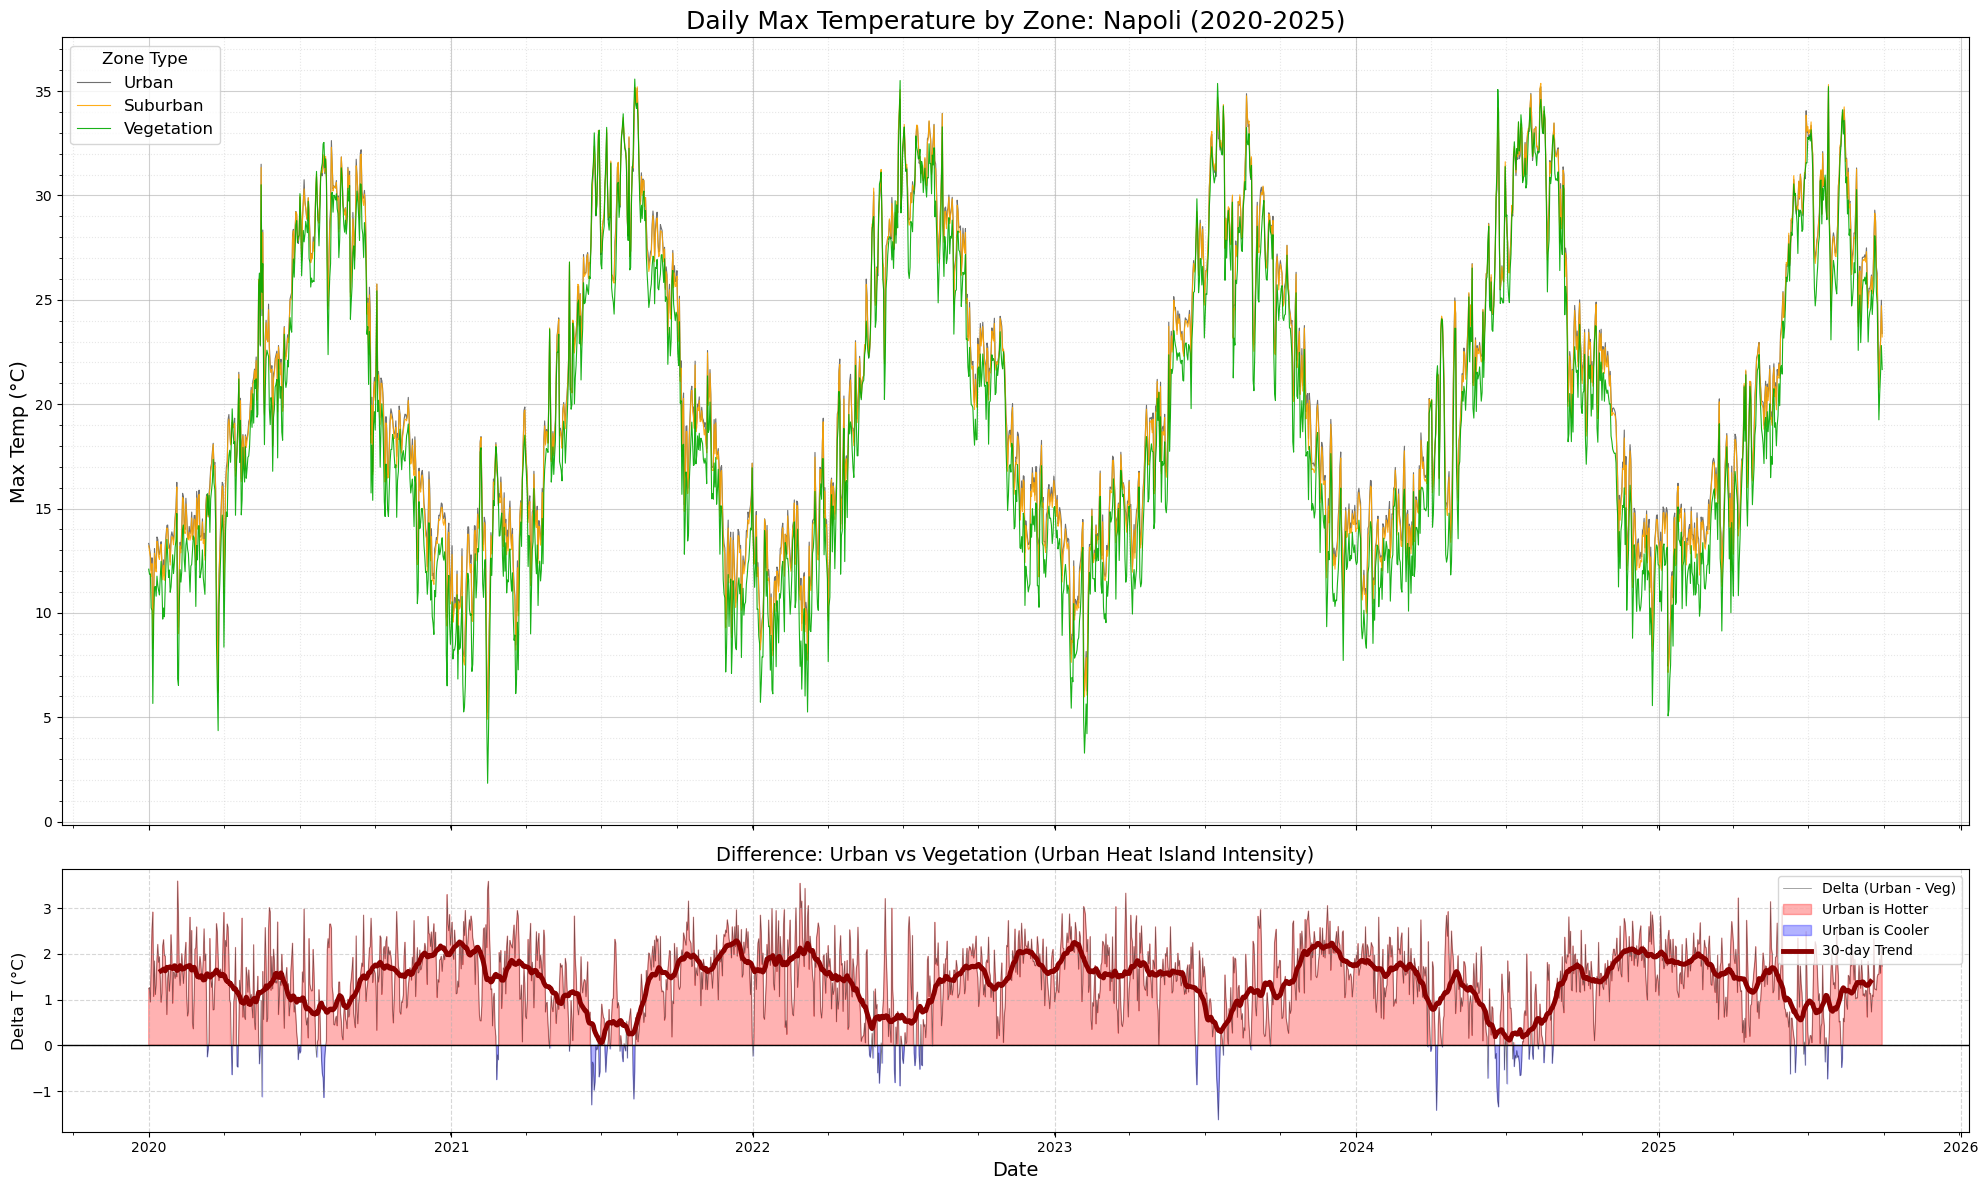

   Done. Top graph shows absolute values, bottom graph shows the precise difference.


In [10]:
# ==========================================
# 8. TIME SERIES ANALYSIS: HIGH RESOLUTION & DELTA
# ==========================================

if 'ds_temp' in locals() and ds_temp is not None and not gdf_big_wgs84.empty:
    
    temp_vars = list(ds_temp.data_vars)
    t_var = 'mx2t' if 'mx2t' in temp_vars else temp_vars[0]

    df_trends = pd.DataFrame(index=pd.to_datetime(ds_temp['time'].values))
    


    data_found = False
    for label, color in categories:
        subset = gdf_big_wgs84[gdf_big_wgs84['macro_label'] == label]
        if not subset.empty:
            pts = subset.geometry.centroid
            lons = xr.DataArray(pts.x.values, dims="subset_cells")
            lats = xr.DataArray(pts.y.values, dims="subset_cells")
            
            try:
                raw_data = ds_temp[t_var].sel(longitude=lons, latitude=lats, method='nearest')
                spatial_mean = raw_data.mean(dim="subset_cells").load()
                df_trends[label] =spatial_mean - 273.15
                data_found = True
            except:
                pass

    if data_found:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        
        for label, color in categories:
            if label in df_trends.columns:
                ax1.plot(df_trends.index, df_trends[label], 
                         label=label, color=color, linewidth=0.8, alpha=0.9)

        ax1.set_title(f"Daily Max Temperature by Zone: {CITY_CONFIG['name']} (2020-2025)", fontsize=18)
        ax1.set_ylabel("Max Temp (°C)", fontsize=14)
        ax1.legend(title="Zone Type", loc="upper left", fontsize=12, title_fontsize=12)
        ax1.grid(True, which='major', linestyle='-', alpha=0.6)
        ax1.grid(True, which='minor', linestyle=':', alpha=0.3)
        ax1.minorticks_on()
        
        y_min = df_trends.min().min()
        y_max = df_trends.max().max()
        ax1.set_ylim(y_min - 2, y_max + 2)

        if "Urban" in df_trends.columns and "Vegetation" in df_trends.columns:
            diff = df_trends["Urban"] - df_trends["Vegetation"]
            
            ax2.plot(df_trends.index, diff, color='black', linewidth=0.5, alpha=0.5, label="Delta (Urban - Veg)")
            ax2.fill_between(df_trends.index, diff, 0, where=(diff>=0), color='red', alpha=0.3, label="Urban is Hotter")
            ax2.fill_between(df_trends.index, diff, 0, where=(diff<0), color='blue', alpha=0.3, label="Urban is Cooler")
            
            ax2.plot(df_trends.index, diff.rolling(30, center=True).mean(), color='darkred', linewidth=3.5, label="30-day Trend")
            
            ax2.set_title("Difference: Urban vs Vegetation (Urban Heat Island Intensity)", fontsize=14)
            ax2.set_ylabel("Delta T (°C)", fontsize=12)
            ax2.axhline(0, color='black', linewidth=1)
            ax2.legend(loc="upper right")
            ax2.grid(True, linestyle='--', alpha=0.5)
        
        plt.xlabel("Date", fontsize=14)
        plt.tight_layout()
        plt.show()
        print("   Done. Top graph shows absolute values, bottom graph shows the precise difference.")
    else:
        print("   No data found for the requested categories.")
else:
    print("   ERROR: Data missing. Run Step 7 first.")

   Computing daily spatial mean across all 35 grid cells...


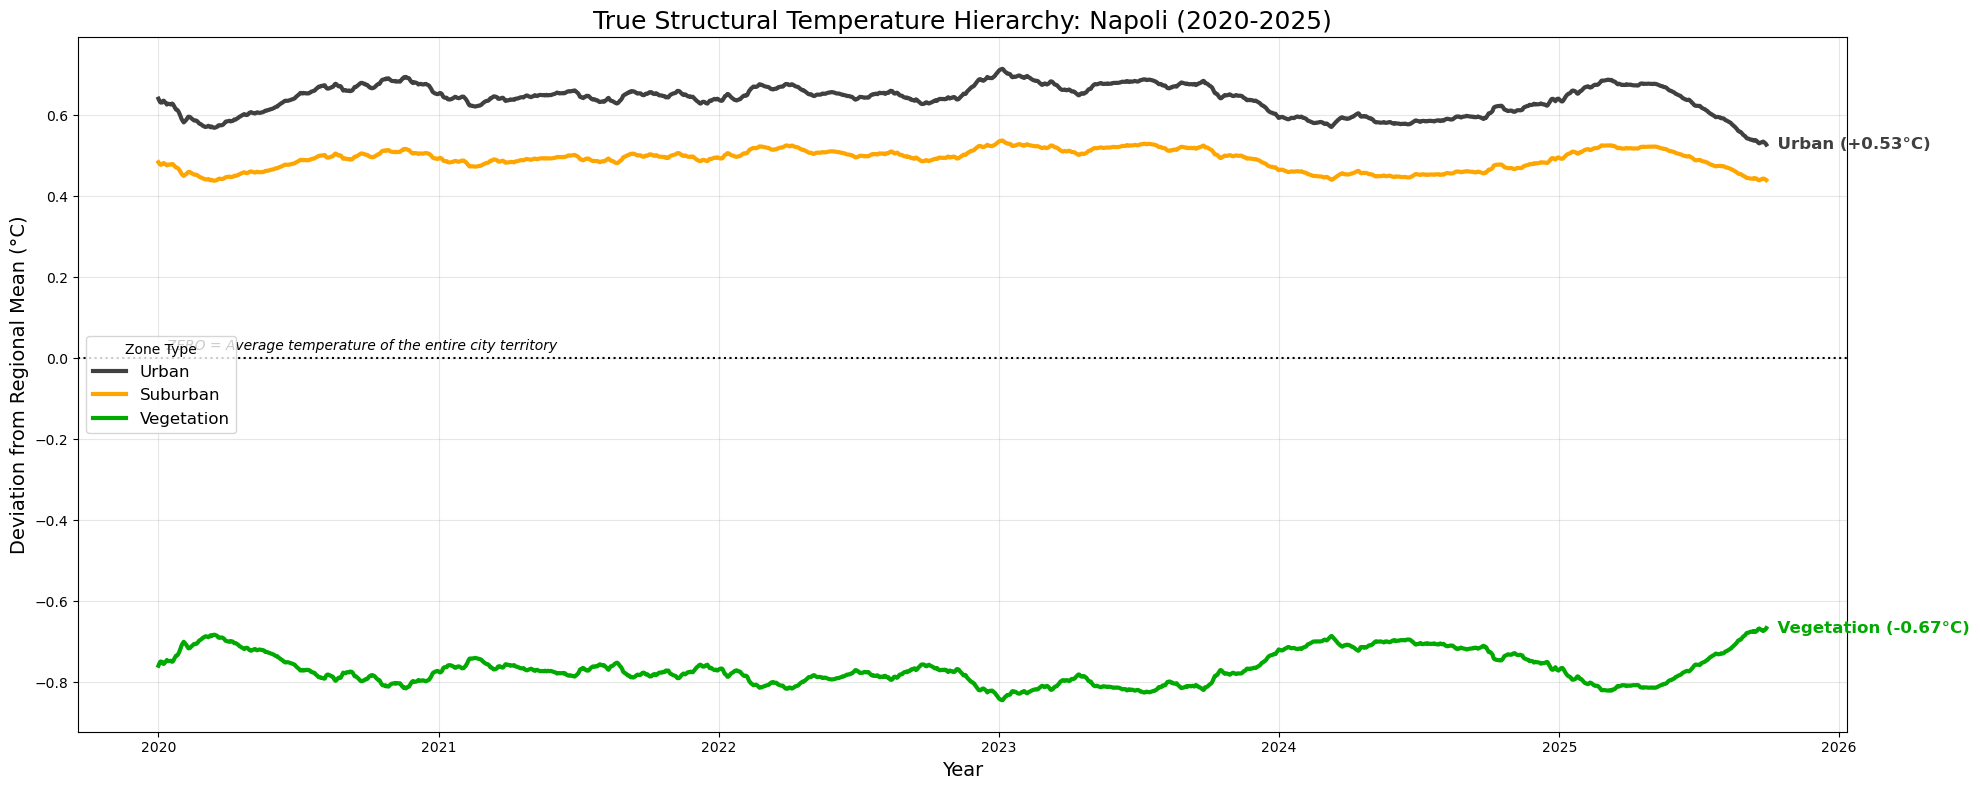

   Final Plot generated successfully.


In [11]:
# ==========================================\n
# 9. FINAL STRUCTURAL ANALYSIS: TRUE SPATIAL ANOMALY
# ==========================================\n

if 'ds_temp' in locals() and 'df_trends' in locals() and not gdf_big_wgs84.empty:

    all_pts=gdf_big_wgs84.geometry.centroid
    all_lons= xr.DataArray(all_pts.x.values, dims="all_cells")
    all_lats= xr.DataArray(all_pts.y.values, dims="all_cells")
    
    temp_vars = list(ds_temp.data_vars)
    t_var = 'mx2t' if 'mx2t' in temp_vars else temp_vars[0]
    
    try:
        print(f"   Computing daily spatial mean across all {len(gdf_big_wgs84)} grid cells...")
        
        all_cells_data =ds_temp[t_var].sel(
            longitude=all_lons, 
            latitude=all_lats, 
            method='nearest'
        )
        
        true_daily_mean =all_cells_data.mean(dim="all_cells").load() - 273.15

        df_true_anom = df_trends.subtract(true_daily_mean.values, axis=0)

        df_final_structural = df_true_anom.rolling(window=365, center=True, min_periods=180).mean()
        plt.figure(figsize=(20, 8))
        
        for label in ["Urban", "Suburban", "Vegetation"]:
            if label in df_final_structural.columns:
                plt.plot(df_final_structural.index, df_final_structural[label], 
                         label=label, color=colors[label], linewidth=3)

        plt.axhline(0, color='black', linestyle=':', linewidth=1.5)
        plt.text(df_final_structural.index[0], 0.02, "  ZERO = Average temperature of the entire city territory", color='black', fontsize=10, style='italic')
        
        plt.title(f"True Structural Temperature Hierarchy: {CITY_CONFIG['name']} (2020-2025)", fontsize=18)
        plt.ylabel("Deviation from Regional Mean (°C)", fontsize=14)
        plt.xlabel("Year", fontsize=14)
        plt.legend(title="Zone Type", loc="center left", fontsize=12)
        plt.grid(True, which='major', linestyle='-', alpha=0.3)
        
        last_valid_idx = df_final_structural.dropna().index[-1]
        for label in ["Urban", "Vegetation"]:
            if label in df_final_structural.columns:
                val = df_final_structural[label].loc[last_valid_idx]
                plt.text(last_valid_idx, val, f"  {label} ({val:+.2f}°C)", 
                         color=colors[label], va='center', fontweight='bold', fontsize=12)

        plt.tight_layout()
        plt.show()
        print("   Final Plot generated successfully.")
        
    except Exception as e:
        print(f"   Error calculating true mean: {e}")

else:
    print("   ERROR: Missing data. Please run 'Step 7' (Load ERA5) and 'Step 8' (Create df_trends) first.")

# WEATHER STATIONS

In [12]:
# ==========================================\n
# 12.1 ADVANCED MAP: LAND USE GRID + WEATHER STATIONS
# ==========================================\n

if 'gdf_big_wgs84' not in locals():
    raise ValueError("CRITICAL: 'gdf_big_wgs84' is missing. Please run Section 6 first to generate the Land Use Grid.")

STATIONS_FILE = os.path.join("data", "ECA_blend_tx", "stations.txt")

def dms_to_decimal(dms_str):
    """Converts string like '+41:48:00' to decimal degrees float."""
    if not isinstance(dms_str, str): return None
    try:
        sign = 1 if dms_str.startswith('+') else -1
        parts = dms_str.strip()[1:].split(':')
        return sign * (float(parts[0]) + float(parts[1])/60 + float(parts[2])/3600)
    except: return None

if os.path.exists(STATIONS_FILE):
    try:
        with open(STATIONS_FILE, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        header_row = 0
        for i, line in enumerate(lines):
            if line.strip().startswith("STAID,STANAME"):
                header_row = i
                break
        df_stations =pd.read_csv(STATIONS_FILE, skiprows=header_row, skipinitialspace=True)
        df_stations.columns = [c.strip() for c in df_stations.columns]
        
        df_stations['lat_dd'] =df_stations['LAT'].apply(dms_to_decimal)
        df_stations['lon_dd']= df_stations['LON'].apply(dms_to_decimal)
        df_stations = df_stations.dropna(subset=['lat_dd', 'lon_dd'])
        
        gdf_stations =gpd.GeoDataFrame(
            df_stations, geometry=gpd.points_from_xy(df_stations.lon_dd, df_stations.lat_dd), crs="EPSG:4326"
        )
        
        city_buffer = gdf_city.to_crs("EPSG:3857").geometry.buffer(15000).to_crs("EPSG:4326").union_all()
        stations_nearby = gdf_stations[gdf_stations.geometry.within(city_buffer)].copy()
        
        stations_tagged = gpd.sjoin(
            stations_nearby, 
            gdf_big_wgs84[['geometry', 'macro_label']], 
            how='left', 
            predicate='within'
        )
        stations_tagged['macro_label'] = stations_tagged['macro_label'].fillna("Outside Grid")
        
        print(f"   Stations found near {CITY_CONFIG['name']}: {len(stations_tagged)}")

        center_lat= gdf_city.geometry.centroid.y.iloc[0]
        center_lon = gdf_city.geometry.centroid.x.iloc[0]
        m_combined =folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles="CartoDB positron")

        folium.GeoJson(
            gdf_big_wgs84,
            name="Land Use Grid (9x9km)",
            style_function=lambda x: {
                "fillColor": x["properties"]["macro_color"], 
                "color": "black", "weight": 0.5, "fillOpacity": 0.6
            },
            tooltip=folium.GeoJsonTooltip(fields=["macro_label"], aliases=["Class:"]),
            popup=folium.GeoJsonPopup(
                fields=["macro_label", "perc_urban", "perc_forest"],
                aliases=["Type", "Urban %", "Forest %"]
            )
        ).add_to(m_combined)

        folium.GeoJson(
            gdf_city,
            name="City Boundary",
            style_function=lambda x: {"color": "red", "fillColor": "none", "weight": 2}
        ).add_to(m_combined)

        station_group =folium.FeatureGroup(name="Weather Stations (Click for Info)", show=True)
        
        for idx, row in stations_tagged.iterrows():
             icon_color = "blue" # default
             if row['macro_label'] == "Urban": icon_color = "black"
             elif row['macro_label'] == "Vegetation": icon_color = "green"
             elif row['macro_label'] == "Suburban": icon_color = "orange"

             html_popup = f"""
             <div style="font-family: sans-serif; width: 200px;">
                 <h4 style="margin-bottom: 5px;">{row['STANAME']}</h4>
                 <b>ID:</b> {row['STAID']}<br>
                 <b>Elev:</b> {row['HGHT']}m<br>
                 <hr style="margin: 5px 0;">
                 <b>Location Type:</b><br>
                 <span style="color: {icon_color}; font-weight: bold; font-size: 14px;">
                    {row['macro_label'].upper()}
                 </span>
             </div>
             """
             
             folium.CircleMarker(
                location=[row['lat_dd'], row['lon_dd']],
                radius=7,
                color="white", weight=1,
                fill=True, fill_color=icon_color, fill_opacity=1,
                popup=folium.Popup(html_popup, max_width=250),
                tooltip=f"{row['STANAME']} ({row['macro_label']})"
            ).add_to(station_group)
            
        station_group.add_to(m_combined)

        folium.LayerControl(collapsed=False).add_to(m_combined)
        
        output_file = os.path.join(OUTPUT_DIR, f"map_STATIONS_2_{CITY_CONFIG['name']}.html")
        m_combined.save(output_file)
        print(f"   SUCCESS: Combined map saved to: {output_file}")
        
        display(m_combined)

    except Exception as e:
        print(f"   Error processing stations layer: {e}")
else:
    print(f"   ERROR: Stations file not found at {STATIONS_FILE}")

   Stations found near Napoli: 10
   SUCCESS: Combined map saved to: output\Napoli\map_STATIONS_2_Napoli.html


   Aggregating station data by category...
      Urban: Aggregated 1 stations.
      Suburban: Aggregated 1 stations.
      Vegetation: Aggregated 8 stations.


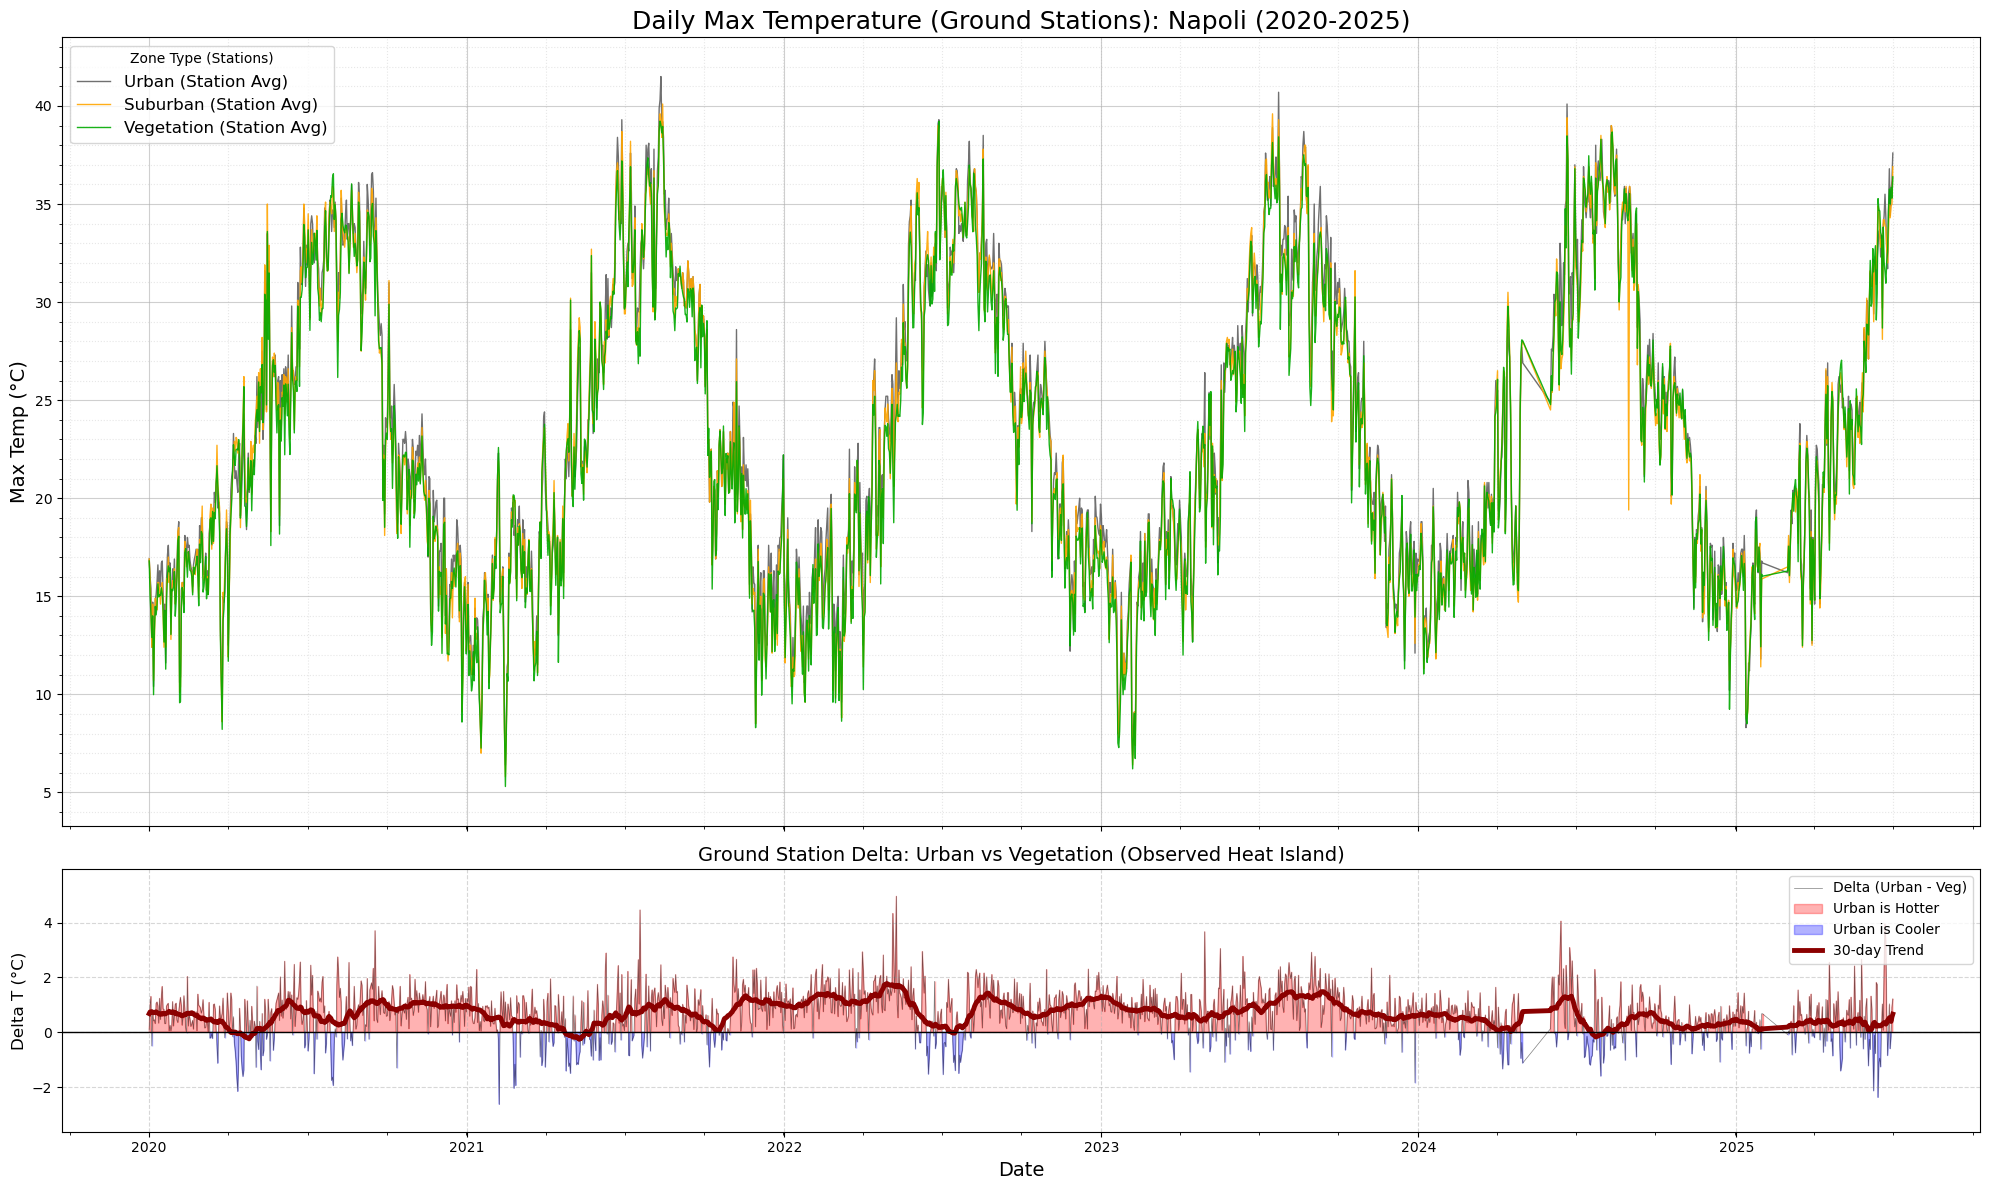

   Done. Analysis based on real ground sensors.


In [13]:
# ==========================================
# 12.5 STATION DATA ANALYSIS: ABSOLUTE TRENDS & DELTA (REPLICATING CELL 8)
# ==========================================

if 'stations_tagged' in locals():
    
    ECA_FOLDER = os.path.join("data", "ECA_blend_tx")

    date_range = pd.date_range(start="2020-01-01", end="2025-12-31", freq='D')
    df_station_abs = pd.DataFrame(index=date_range)
    
    data_found = False

    print("   Aggregating station data by category...")
    
    for label, color in categories:
        subset = stations_tagged[stations_tagged['macro_label'] == label]
        
        if not subset.empty:
            category_series_list = []
            
            for idx, row in subset.iterrows():
                sta_id_str = f"TX_STAID{int(row['STAID']):06d}.txt"
                file_path = os.path.join(ECA_FOLDER, sta_id_str)
                
                if os.path.exists(file_path):
                    try:
                        df_st = pd.read_csv(file_path, skiprows=20, skipinitialspace=True)
                        df_st.columns = [c.strip() for c in df_st.columns]
                        
                        df_st['time'] = pd.to_datetime(df_st['DATE'], format='%Y%m%d')
                        df_st =df_st[df_st['time'] >= '2020-01-01']
                        df_st= df_st[(df_st['Q_TX'] == 0) & (df_st['TX'] > -1000)]
                        
                        if not df_st.empty:
                            df_st.set_index('time', inplace=True)
                            temp_series = df_st['TX'] * 0.1
                            category_series_list.append(temp_series)
                            
                    except Exception:
                        continue
            if category_series_list:
                combined_df = pd.concat(category_series_list, axis=1)
                daily_mean = combined_df.mean(axis=1)
                
                df_station_abs[label] = daily_mean
                data_found = True
                print(f"      {label}: Aggregated {len(category_series_list)} stations.")
            else:
                print(f"      {label}: No valid data found in files.")
        else:
            print(f"      {label}: No stations tagged with this label.")

    df_station_abs.dropna(how='all', inplace=True)

    if data_found and not df_station_abs.empty:
        
        fig, (ax1, ax2)=plt.subplots(2, 1, figsize=(20, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        
        for label, color in categories:
            if label in df_station_abs.columns:
                ax1.plot(df_station_abs.index, df_station_abs[label], 
                         label=f"{label} (Station Avg)", color=color, linewidth=1, alpha=0.9)

        ax1.set_title(f"Daily Max Temperature (Ground Stations): {CITY_CONFIG['name']} (2020-2025)", fontsize=18)
        ax1.set_ylabel("Max Temp (°C)", fontsize=14)
        ax1.legend(title="Zone Type (Stations)", loc="upper left", fontsize=12)
        ax1.grid(True, which='major', linestyle='-', alpha=0.6)
        ax1.grid(True, which='minor', linestyle=':', alpha=0.3)
        ax1.minorticks_on()
        
        valid_vals = df_station_abs.select_dtypes(include=['number'])
        if not valid_vals.empty:
            y_min = valid_vals.min().min()
            y_max = valid_vals.max().max()
            ax1.set_ylim(y_min - 2, y_max + 2)

        if "Urban" in df_station_abs.columns and "Vegetation" in df_station_abs.columns:
            common_idx = df_station_abs.index
            s_urban = df_station_abs["Urban"]
            s_veg = df_station_abs["Vegetation"]
            
            diff =s_urban - s_veg
            
            ax2.plot(diff.index, diff, color='black', linewidth=0.5, alpha=0.5, label="Delta (Urban - Veg)")
            ax2.fill_between(diff.index, diff, 0, where=(diff>=0), color='red', alpha=0.3, label="Urban is Hotter")
            ax2.fill_between(diff.index, diff, 0, where=(diff<0), color='blue', alpha=0.3, label="Urban is Cooler")
            
            diff_smooth = diff.rolling(30, center=True, min_periods=10).mean()
            ax2.plot(diff_smooth.index, diff_smooth, color='darkred', linewidth=3.5, label="30-day Trend")
            
            ax2.set_title("Ground Station Delta: Urban vs Vegetation (Observed Heat Island)", fontsize=14)
            ax2.set_ylabel("Delta T (°C)", fontsize=12)
            ax2.axhline(0, color='black', linewidth=1)
            ax2.legend(loc="upper right")
            ax2.grid(True, linestyle='--', alpha=0.5)
            
            ax2.set_ylim(max(-10, diff.min()-1), min(10, diff.max()+1))
        
        plt.xlabel("Date", fontsize=14)
        plt.tight_layout()
        plt.show()
        print("   Done. Analysis based on real ground sensors.")
        
    else:
        print("   No sufficient station data found to plot trends.")

else:
    print("   ERROR: 'stations_tagged' not found. Please run Cell 12.1 first.")

   Total stations classified in grid: 10
   Stations breakdown by Land Use:
      - Vegetation: 8
      - Suburban: 1
      - Urban: 1

   Data Availability Check:
   Urban: Data available until 2025-06-30
   Suburban: Data available until 2025-06-30
   Vegetation: Data available until 2025-06-30


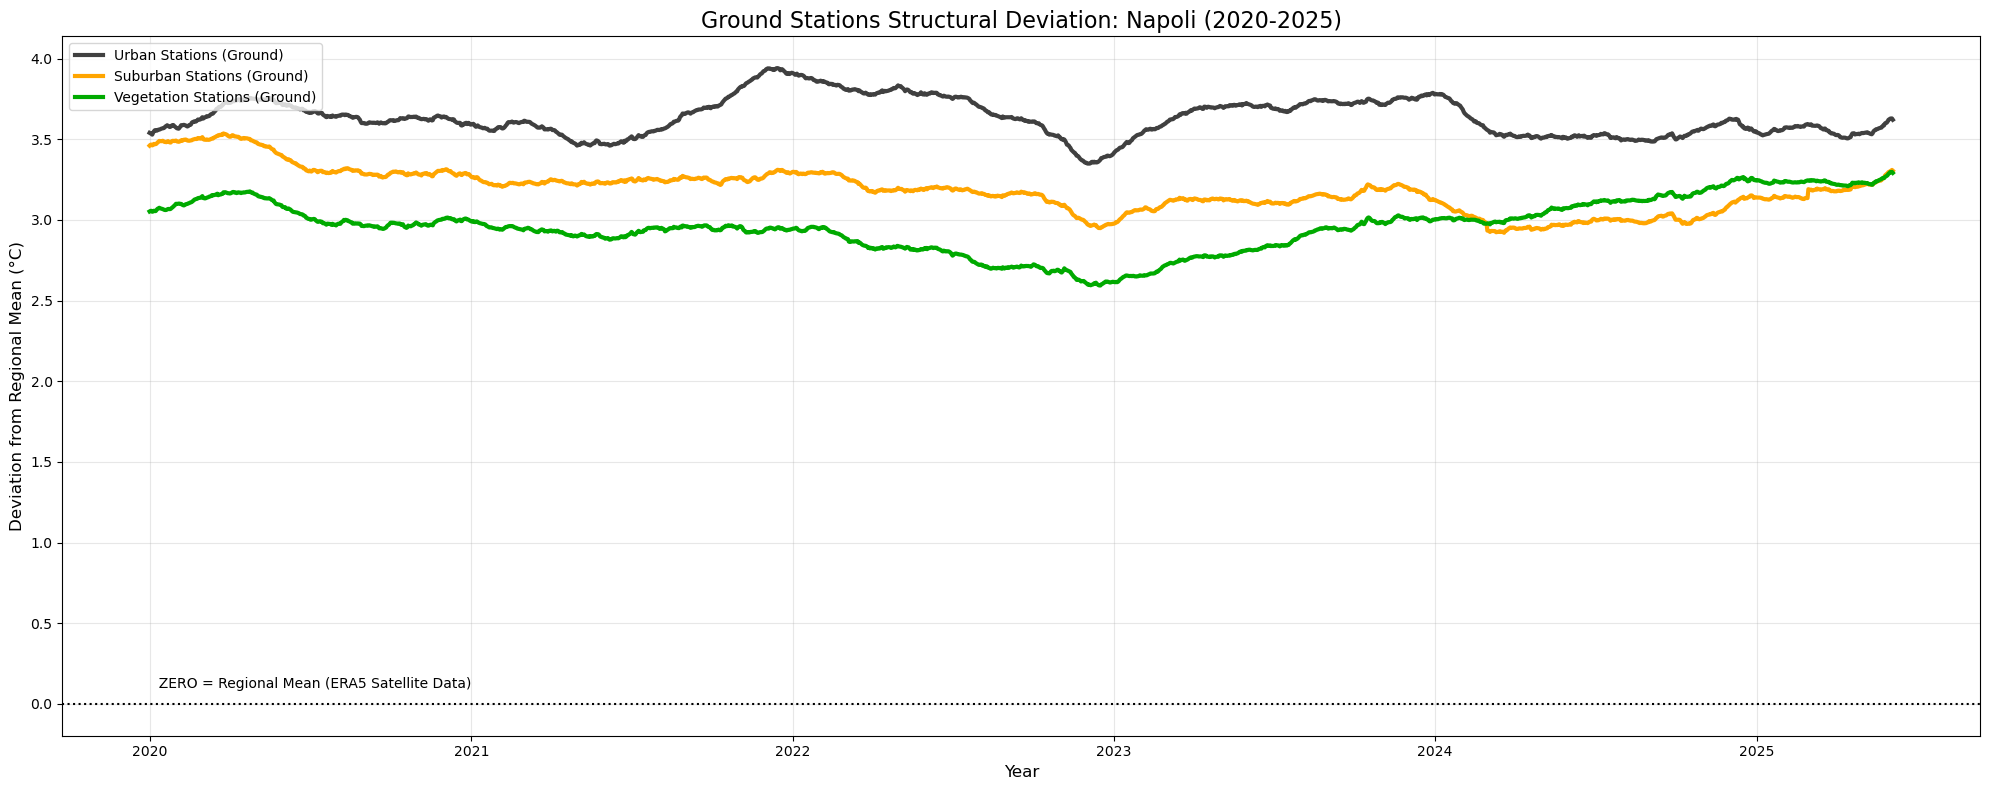

   Station analysis complete.


In [14]:
# ==========================================\n
# 13. WEATHER STATIONS ANALYSIS: STRUCTURAL DEVIATION (FIXED FOR 12.1)
# ==========================================\n

if 'stations_tagged' in locals() and 'true_daily_mean' in locals():

    valid_stations = stations_tagged[
        (stations_tagged['macro_label'] != "Outside Grid") & 
        (stations_tagged['macro_label'].notna())
    ].copy()
    
    print(f"   Total stations classified in grid: {len(valid_stations)}")
    print("   Stations breakdown by Land Use:")
    counts = valid_stations['macro_label'].value_counts()
    for label, count in counts.items():
        print(f"      - {label}: {count}")

    ECA_FOLDER = os.path.join("data", "ECA_blend_tx")
    
    cat_data = {"Urban": [], "Suburban": [], "Vegetation": []}
    
    for idx, row in valid_stations.iterrows():
        sta_id_str = f"TX_STAID{int(row['STAID']):06d}.txt"
        file_path = os.path.join(ECA_FOLDER, sta_id_str)
        label = row['macro_label']
        
        if os.path.exists(file_path):
            try:
                df_st = pd.read_csv(file_path, skiprows=20, skipinitialspace=True)
                df_st.columns = [c.strip() for c in df_st.columns]
                
                df_st['time'] = pd.to_datetime(df_st['DATE'], format='%Y%m%d')
                df_st = df_st[df_st['time'] >= '2020-01-01']
                df_st = df_st[(df_st['Q_TX'] == 0) & (df_st['TX'] > -1000)]
                df_st['temp_c'] = df_st['TX'] * 0.1
                df_st.set_index('time', inplace=True)
                
                if not df_st.empty:
                    cat_data[label].append(df_st['temp_c'])
                
            except Exception as e:
                print(f"   Error reading station {row['STAID']}: {e}")

    df_station_trends = pd.DataFrame(index=true_daily_mean.time.values)
    
    print("\n   Data Availability Check:")
    for label in ["Urban", "Suburban", "Vegetation"]:
        if cat_data[label]:
            combined_df = pd.concat(cat_data[label], axis=1)
            daily_avg_cat = combined_df.mean(axis=1)
            
            last_valid_date = daily_avg_cat.dropna().index.max()
            print(f"   {label}: Data available until {last_valid_date.date()}")
            
            daily_avg_cat = daily_avg_cat.reindex(df_station_trends.index)
            anomaly = daily_avg_cat - true_daily_mean.values
            df_station_trends[label] = anomaly
        else:
            print(f"  {label}: No data found.")

    df_station_structural = df_station_trends.rolling(window=365, center=True, min_periods=180).mean()

    if not df_station_structural.dropna(how='all').empty:
        plt.figure(figsize=(20, 8))
        
        
        plotted_something = False
        for label in ["Urban", "Suburban", "Vegetation"]:
            if label in df_station_structural.columns:
                if not df_station_structural[label].isna().all():
                    plt.plot(df_station_structural.index, df_station_structural[label], 
                             label=f"{label} Stations (Ground)", color=colors[label], linewidth=3, linestyle='-')
                    plotted_something = True
        
        if plotted_something:
            plt.axhline(0, color='black', linestyle=':', linewidth=1.5)
            plt.text(df_station_structural.index[0], 0.1, "  ZERO = Regional Mean (ERA5 Satellite Data)", color='black', fontsize=10)
            
            plt.title(f"Ground Stations Structural Deviation: {CITY_CONFIG['name']} (2020-2025)", fontsize=16)
            plt.ylabel("Deviation from Regional Mean (°C)", fontsize=12)
            plt.xlabel("Year", fontsize=12)
            plt.legend(loc="upper left")
            plt.grid(True, which='major', linestyle='-', alpha=0.3)
            plt.tight_layout()
            plt.show()
            print("   Station analysis complete.")
        else:
            print("   No sufficient station data found for smoothing (requires ~1 year of data).")
    else:
        print("   No station data available to plot.")

else:
    print("   ERROR: Missing dependencies. Run Step 9 (Final) and Step 12.1 first.")
    print("   (Ensure 'stations_tagged' from 12.1 and 'true_daily_mean' from 9 are in memory).")

In [15]:
# ==========================================\n
# 14. DIAGNOSTICS: CHECK INDIVIDUAL STATION END DATES
# ==========================================\n


if 'stations_tagged' in locals():
    
    ECA_FOLDER= os.path.join("data", "ECA_blend_tx")
    
    diagnosis_list = []

    print(f"   Inspecting {len(stations_tagged)} stations...")

    for idx, row in stations_tagged.iterrows():
        sta_id_str = f"TX_STAID{int(row['STAID']):06d}.txt"
        file_path = os.path.join(ECA_FOLDER, sta_id_str)
        
        last_date = "File Missing"
        status = "Error"
        
        if os.path.exists(file_path):
            try:

                df_diag= pd.read_csv(file_path, skiprows=20, skipinitialspace=True)
                df_diag.columns = [c.strip() for c in df_diag.columns]
                
                valid_data =df_diag[df_diag['Q_TX'] == 0]
                
                if not valid_data.empty:
                    max_date_str = str(valid_data['DATE'].max())
                    last_date = f"{max_date_str[:4]}-{max_date_str[4:6]}-{max_date_str[6:]}"
                    status = "Active"
                else:
                    last_date = "No Valid Data"
                    status = "Empty"
                    
            except Exception as e:
                status = "Read Error"
        
        diagnosis_list.append({
            "ID": row['STAID'],
            "Name": row['STANAME'],
            "Class": row['macro_label'],
            "Last_Available_Date": last_date,
            "Status": status
        })

    df_diagnosis =pd.DataFrame(diagnosis_list)
    
    df_diagnosis= df_diagnosis.sort_values(by=['Class', 'Name'])

    print("\n--- URBAN STATIONS REPORT ---")
    print(df_diagnosis[df_diagnosis['Class'] == 'Urban'][['Name', 'Last_Available_Date']])
    
    print("\n--- SUBURBAN STATIONS REPORT (Sample) ---")
    print(df_diagnosis[df_diagnosis['Class'] == 'Suburban'][['Name', 'Last_Available_Date']].head())

    print("\n--- VEGETATION STATIONS REPORT (Sample) ---")
    print(df_diagnosis[df_diagnosis['Class'] == 'Vegetation'][['Name', 'Last_Available_Date']].head())

else:
    print("   ERROR: 'stations_tagged' missing. Run Step 12.1 first.")

   Inspecting 10 stations...

--- URBAN STATIONS REPORT ---
                                           Name Last_Available_Date
3  CASAREA                                               2025-06-30

--- SUBURBAN STATIONS REPORT (Sample) ---
                                           Name Last_Available_Date
0  ACERRA                                                2025-06-30

--- VEGETATION STATIONS REPORT (Sample) ---
                                           Name Last_Available_Date
1  AIROLA                                                2025-06-30
2  BOSCOTRECASE                                          2025-06-30
8  CASAMARCIANO-04                                       2025-06-30
4  FIAIANO                                               2025-06-30
5  FONTENOVELLA                                          2025-06-30


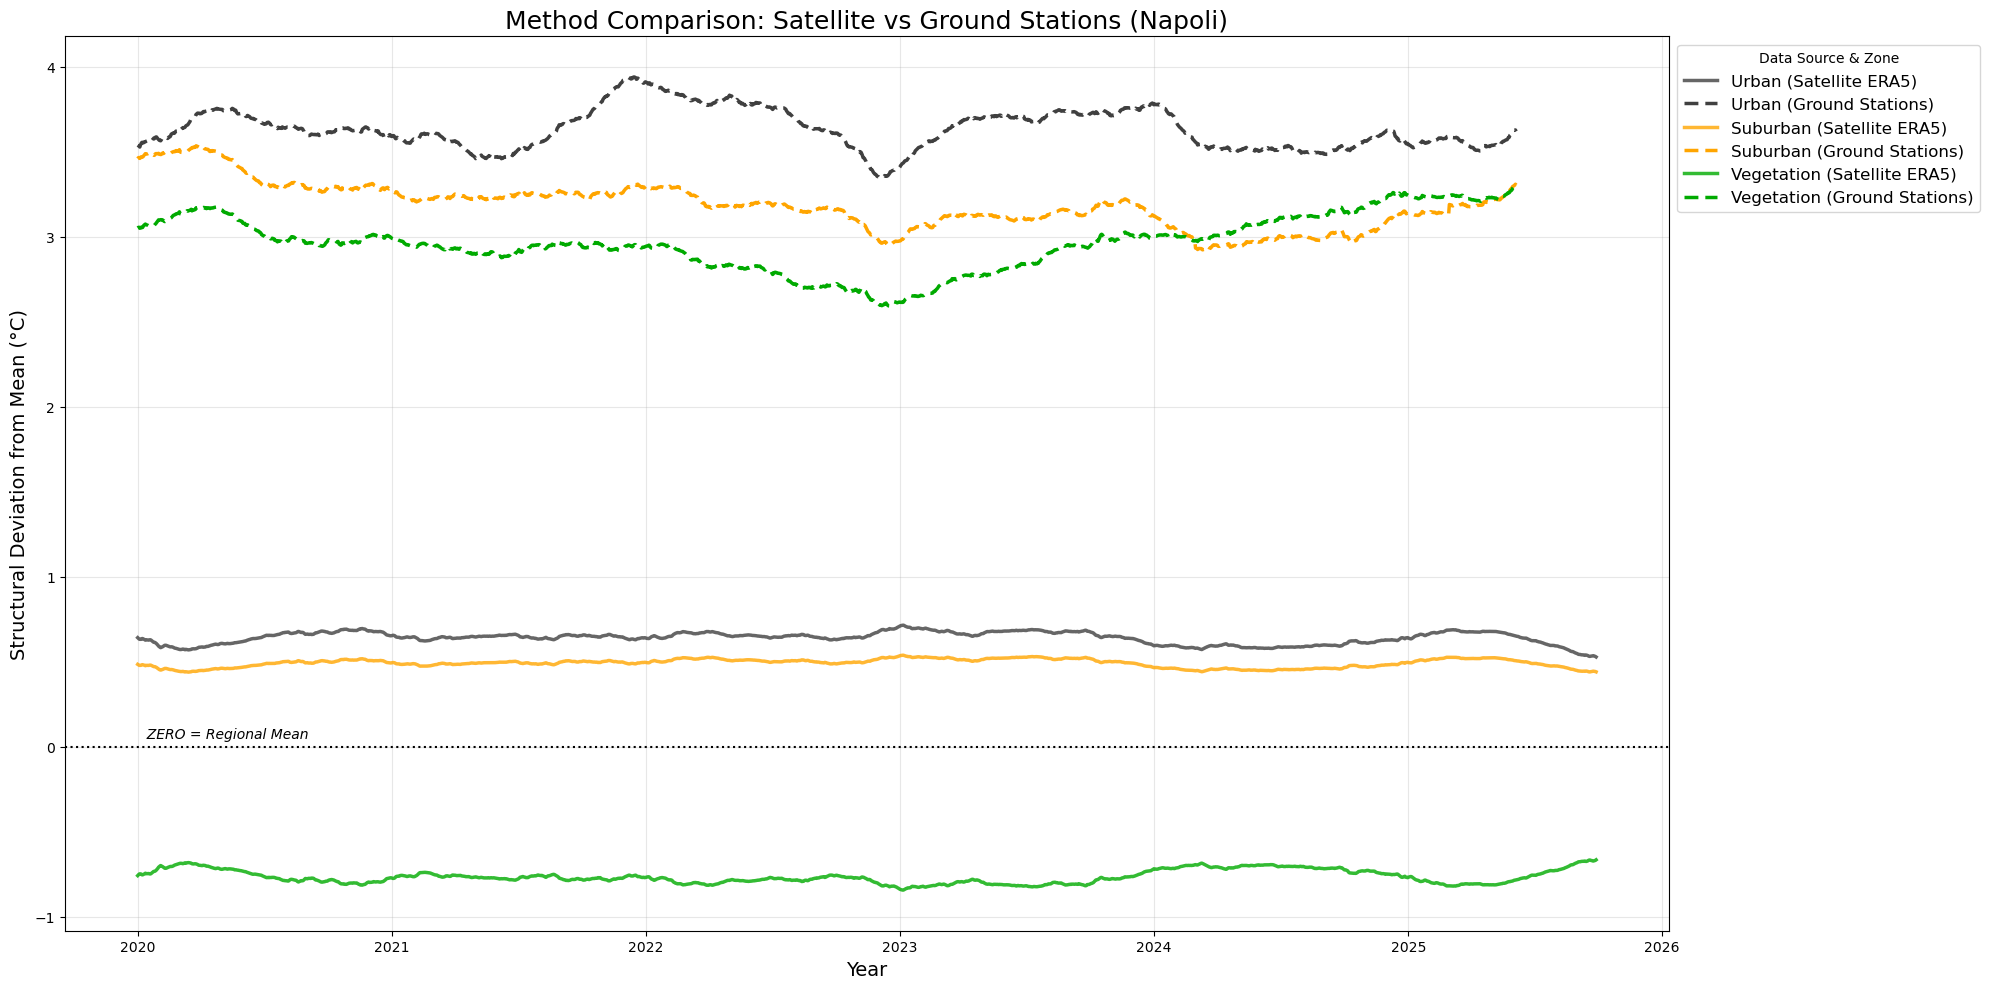

   Comparison Plot Generated.
  - Solid Lines: Satellite Data (Continuous coverage)
   - Dashed Lines: Ground Stations (Point data, may have gaps)


In [16]:
# ==========================================\n
# 15. COMPARISON: SATELLITE (ERA5) VS GROUND STATIONS
# ==========================================\n

if 'df_final_structural' in locals() and 'df_station_structural' in locals():
    
    plt.figure(figsize=(20, 10))
    for label in ["Urban", "Suburban", "Vegetation"]:
        color = colors[label]
        
        if label in df_final_structural.columns:
            plt.plot(df_final_structural.index, df_final_structural[label], 
                     color=color, linestyle='-', linewidth=2.5, alpha=0.8,
                     label=f"{label} (Satellite ERA5)")
            
        if label in df_station_structural.columns:
            if not df_station_structural[label].isna().all():
                plt.plot(df_station_structural.index, df_station_structural[label], 
                         color=color, linestyle='--', linewidth=2.5, 
                         dashes=(4, 2), # Custom dash pattern
                         label=f"{label} (Ground Stations)")

    plt.axhline(0, color='black', linestyle=':', linewidth=1.5)
    plt.text(df_final_structural.index[0], 0.05, "  ZERO = Regional Mean", color='black', fontsize=10, style='italic')
    
    plt.title(f"Method Comparison: Satellite vs Ground Stations ({CITY_CONFIG['name']})", fontsize=18)
    plt.ylabel("Structural Deviation from Mean (°C)", fontsize=14)
    plt.xlabel("Year", fontsize=14)
    
    plt.legend(title="Data Source & Zone", loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)
    
    plt.grid(True, which='major', linestyle='-', alpha=0.3)
    plt.tight_layout()
    
    plt.show()
    print("   Comparison Plot Generated.")
    print("  - Solid Lines: Satellite Data (Continuous coverage)")
    print("   - Dashed Lines: Ground Stations (Point data, may have gaps)")

else:
    print("  ERROR: Missing input dataframes.")
    print("   Please ensure you have run 'Step 9' (Satellite Analysis) and 'Step 13' (Station Analysis).")

# 3D plot

In [17]:
# ==========================================
# 16. 3D TEMPERATURE PLOT: ACCENTUATED HEIGHTS
# ==========================================
TARGET_DATE = '2024-08-09'



if 'ds_temp' in locals() and not gdf_big_wgs84.empty:
    try:
        centroids = gdf_big_wgs84.geometry.centroid
        lons = centroids.x.values
        lats = centroids.y.values
        labels = gdf_big_wgs84['macro_label'].values

        t_var = 'mx2t' if 'mx2t' in ds_temp.data_vars else list(ds_temp.data_vars)[0]
        data_day = ds_temp[t_var].sel(time=TARGET_DATE, method='nearest')
        temp_vals = data_day.sel(
            longitude=xr.DataArray(lons, dims="z"),
            latitude=xr.DataArray(lats, dims="z"),
            method='nearest'
        ).values

        if np.nanmean(temp_vals) > 200:
            temp_vals = temp_vals - 273.15

        z_min_val = np.nanmin(temp_vals)
        z_floor = z_min_val - 1.0  

        fig = go.Figure()

        x_mesh, y_mesh, z_mesh = [], [], []
        i_mesh, j_mesh, k_mesh = [], [], []
        face_colors = []
        cursor = 0

        for idx, row in gdf_big_wgs84.iterrows():
            geom = row.geometry
            label = row['macro_label']
            color = COLOR_MAP.get(label, 'lightgrey')
            minx, miny, maxx, maxy = geom.bounds

            x_mesh.extend([minx, maxx, maxx, minx])
            y_mesh.extend([miny, miny, maxy, maxy])
            z_mesh.extend([z_floor] * 4)

            i_mesh.extend([cursor, cursor])
            j_mesh.extend([cursor+1, cursor+2])
            k_mesh.extend([cursor+2, cursor+3])
            face_colors.extend([color, color])
            cursor += 4

        fig.add_trace(go.Mesh3d(
            x=x_mesh, y=y_mesh, z=z_mesh,
            i=i_mesh, j=j_mesh, k=k_mesh,
            facecolor=face_colors,
            opacity=0.5, 
            name='Land Use Map', hoverinfo='skip'
        ))

        city_x, city_y, city_z = [], [], []
        geoms = [city_geom] if city_geom.geom_type == 'Polygon' else city_geom.geoms
        for geom in geoms:
            xx, yy = geom.exterior.xy
            city_x.extend(list(xx) + [None])
            city_y.extend(list(yy) + [None])
            city_z.extend([z_floor + 0.05] * len(xx) + [None]) 

        fig.add_trace(go.Scatter3d(
            x=city_x, y=city_y, z=city_z,
            mode='lines', line=dict(color='red', width=6),
            name='Boundary', hoverinfo='skip'
        ))

        stem_x, stem_y, stem_z = [], [], []
        for x, y, z in zip(lons, lats, temp_vals):
            stem_x.extend([x, x, None])
            stem_y.extend([y, y, None])
            stem_z.extend([z_floor, z, None])

        fig.add_trace(go.Scatter3d(
            x=stem_x, y=stem_y, z=stem_z,
            mode='lines', line=dict(color='gray', width=1, dash='dot'),
            hoverinfo='skip', showlegend=False
        ))
        fig.add_trace(go.Mesh3d(
            x=lons, y=lats, z=temp_vals,
            intensity=temp_vals,
            colorscale='Jet', 
            opacity=0.6,
            delaunayaxis='z',
            name='Superface Temp', hoverinfo='skip'
        ))

        point_colors = [COLOR_MAP.get(l, 'gray') for l in labels]
        fig.add_trace(go.Scatter3d(
            x=lons, y=lats, z=temp_vals,
            mode='markers',
            marker=dict(size=6, color=point_colors, line=dict(color='white', width=1)),
            text=[f"Zone: {l}<br>Temp: {t:.2f}°C" for l, t in zip(labels, temp_vals)],
            hoverinfo='text', name='Temp Cell'
        ))

        fig.update_layout(
            title=f"3D Temp: {CITY_CONFIG['name']} ({TARGET_DATE}) - Exaggerated Scale",
            scene=dict(
                xaxis=dict(title='', showticklabels=False, showgrid=False, backgroundcolor="white"),
                yaxis=dict(title='', showticklabels=False, showgrid=False, backgroundcolor="white"),
                
                zaxis=dict(title='Temp (°C)', backgroundcolor="#F0F8FF", showgrid=True),
                
                aspectmode='manual',
                aspectratio=dict(x=1, y=1, z=2.5),
                
                camera=dict(eye=dict(x=1.4, y=-1.4, z=0.5))
            ),
            width=1000, height=800,
            margin=dict(l=0, r=0, b=0, t=50)
        )

        output_file = os.path.join(OUTPUT_DIR, f"3D_{CITY_CONFIG['name']}.html")
        fig.write_html(output_file)
        print(f"   Graph saved in: {output_file}")
        
        fig.show()

    except Exception as e:
        print(f"   Error: {e}")
        import traceback
        traceback.print_exc()
else:
    print(" Missing data.")

   Error: name 'go' is not defined


Traceback (most recent call last):
  File "C:\Users\drugm\AppData\Local\Temp\ipykernel_31544\3864923975.py", line 29, in <module>
    fig = go.Figure()
NameError: name 'go' is not defined


# REGRESSION

In [18]:
# ==========================================
# REGRESSION 1: USING ONLY 9km LABEL (URBAN / SUBURBAN / VEGETATION)
# ==========================================

required_vars = ["gdf_big_wgs84", "ds_temp", "ds_precip", "ds_wind"]
for name in required_vars:
    if name not in globals():
        raise ValueError(f"Missing '{name}'. Please run Sections 6, 7, 8, 9 first.")

if "macro_label" in gdf_big_wgs84.columns:
    label_col = "macro_label"
elif "macrolabel" in gdf_big_wgs84.columns:
    label_col = "macrolabel"
else:
    raise ValueError(
        "Could not find a macro label column in gdf_big_wgs84. "
        "Expected one of: 'macro_label', 'macrolabel'."
    )

print(f"  Using macro label column: '{label_col}'")

centroids = gdf_big_wgs84.geometry.centroid

static_label_df = pd.DataFrame({
    "cell_id": gdf_big_wgs84["cell_id"].values,
    "lon": centroids.x.values,
    "lat": centroids.y.values,
    "macrolabel": gdf_big_wgs84[label_col].values, 
})

print(f"  Static cells found: {len(static_label_df)}")
print("  Unique macro labels:", static_label_df["macrolabel"].unique())

time_temp = pd.to_datetime(ds_temp["time"].values)
time_precip = pd.to_datetime(ds_precip["time"].values)
time_wind = pd.to_datetime(ds_wind["time"].values)

common_times = np.intersect1d(
    np.intersect1d(time_temp, time_precip),
    time_wind
)

if len(common_times) == 0:
    raise ValueError("No common times found between temp, precip and wind datasets.")

print(
    f"  Common time steps: {len(common_times)} "
    f"(from {pd.to_datetime(common_times).min().date()} "
    f"to {pd.to_datetime(common_times).max().date()})"
)

ds_temp_aligned =ds_temp.sel(time=common_times)
ds_precip_aligned= ds_precip.sel(time=common_times)
ds_wind_aligned = ds_wind.sel(time=common_times)

temp_vars = list(ds_temp_aligned.data_vars)
t_var = "mx2t" if "mx2t" in temp_vars else temp_vars[0]

precip_vars = list(ds_precip_aligned.data_vars)
p_var = "tp" if "tp" in precip_vars else precip_vars[0]

wind_vars = list(ds_wind_aligned.data_vars)
u_var_candidates = [v for v in wind_vars if "u10" in v]
v_var_candidates = [v for v in wind_vars if "v10" in v]
if not u_var_candidates or not v_var_candidates:
    raise ValueError(f"Could not find u10/v10 in wind dataset vars: {wind_vars}")
u_var = u_var_candidates[0]
v_var = v_var_candidates[0]

times =pd.to_datetime(ds_temp_aligned["time"].values)

lons_da =xr.DataArray(static_label_df["lon"].values, dims="cell")
lats_da= xr.DataArray(static_label_df["lat"].values, dims="cell")

temp_all =ds_temp_aligned[t_var].sel(longitude=lons_da, latitude=lats_da, method="nearest")   
precip_all= ds_precip_aligned[p_var].sel(longitude=lons_da, latitude=lats_da, method="nearest")
u_all =ds_wind_aligned[u_var].sel(longitude=lons_da, latitude=lats_da, method="nearest")
v_all= ds_wind_aligned[v_var].sel(longitude=lons_da, latitude=lats_da, method="nearest")      

temp_c = temp_all.values - 273.15          # K -> °C
precip_mm = precip_all.values * 1000.0     # m -> mm
u_vals = u_all.values
v_vals = v_all.values
wind_speed = np.sqrt(u_vals**2 + v_vals**2)  # m/s

print("  Shapes (time, cells):")
print("    temp   :", temp_c.shape)
print("    precip :", precip_mm.shape)
print("    wind   :", wind_speed.shape)

if not (temp_c.shape == precip_mm.shape == wind_speed.shape):
    raise ValueError("Shapes of temp, precip and wind arrays do not match after alignment.")


n_time, n_cell = temp_c.shape
print(f"  Data matrix shape: time={n_time}, cells={n_cell}")

multi_index = pd.MultiIndex.from_product(
    [times, static_label_df["cell_id"]],
    names=["date", "cell_id"]
)

expected_len = len(multi_index)
actual_len = temp_c.size
print(f"  Expected rows: {expected_len}, array length: {actual_len}")

if actual_len != expected_len:
    raise ValueError(
        f"Mismatch: expected {expected_len} entries (time*cells), "
        f"but have {actual_len}. Check time alignment and cell count."
    )

df_label = pd.DataFrame(
    {
        "temp_c": temp_c.ravel(order="C"),
        "precip_mm": precip_mm.ravel(order="C"),
        "wind_speed": wind_speed.ravel(order="C"),
    },
    index=multi_index
).reset_index()

df_label = df_label.merge(static_label_df, on="cell_id", how="left")

print(f"  Long dataframe rows: {len(df_label)}")


daily_mean = df_label.groupby("date")["temp_c"].mean().rename("city_mean_temp_c")
df_label= df_label.merge(daily_mean, on="date", how="left")

df_label["temp_anomaly"] = df_label["temp_c"] - df_label["city_mean_temp_c"]

df_label["doy"] = df_label["date"].dt.dayofyear

print("  NaN counts before dropna:")
print(df_label[["temp_anomaly", "wind_speed", "precip_mm", "macrolabel"]].isna().sum())

df_label = df_label.dropna(subset=["temp_anomaly", "wind_speed", "precip_mm", "macrolabel"])
print(f"  Rows after dropping NaNs: {len(df_label)}")


dummies= pd.get_dummies(df_label["macrolabel"], prefix="zone", drop_first=False)

feature_cols_labels = list(dummies.columns) + ["wind_speed", "precip_mm", "doy"]

X = np.hstack([
    dummies.values,
    df_label[["wind_speed", "precip_mm", "doy"]].values
])
y = df_label["temp_anomaly"].values

print("  Features used:", feature_cols_labels)

unique_dates = np.sort(df_label["date"].unique())
cutoff_index = int(len(unique_dates) * 0.8)
cutoff_date = unique_dates[cutoff_index]

print(
    f"  Train up to date: {pd.to_datetime(cutoff_date).date()} "
    f"(about 80% of days)"
)

train_mask = df_label["date"] <= cutoff_date
test_mask = ~train_mask

X_train, y_train =X[train_mask.values], y[train_mask.values]
X_test, y_test= X[test_mask.values], y[test_mask.values]

print(f" Train samples: {len(y_train)}, Test samples: {len(y_test)}")

model_label = LinearRegression()
model_label.fit(X_train, y_train)

y_pred = model_label.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\n=== Linear Regression Results (Temperature Anomaly, LABEL-BASED) ===")
print("Coefficients (same order as feature_cols_labels):")
for name, coef in zip(feature_cols_labels, model_label.coef_):
    print(f"  {name:>12}: {coef:+.4f}  (°C per unit)")

print(f"\nIntercept: {model_label.intercept_:+.4f} °C")
print(f"Test R²:  {r2:.3f}")
print(f"Test RMSE: {rmse:.3f} °C")

regression_results_label = {
    "df_label": df_label,
    "model_label": model_label,
    "feature_cols_labels": feature_cols_labels,
    "r2_test": r2,
    "rmse_test": rmse,
}
print("\nSaved regression_results_label dict for potential further analysis/plots.")


  Using macro label column: 'macro_label'
  Static cells found: 35
  Unique macro labels: ['Suburban' 'Vegetation' 'Urban']
  Common time steps: 2098 (from 2020-01-01 to 2025-09-28)
  Shapes (time, cells):
    temp   : (2098, 35)
    precip : (2098, 35)
    wind   : (2098, 35)
  Data matrix shape: time=2098, cells=35
  Expected rows: 73430, array length: 73430
  Long dataframe rows: 73430
  NaN counts before dropna:
temp_anomaly    37764
wind_speed      37764
precip_mm       37764
macrolabel          0
dtype: int64
  Rows after dropping NaNs: 35666
  Features used: ['zone_Suburban', 'zone_Urban', 'zone_Vegetation', 'wind_speed', 'precip_mm', 'doy']
  Train up to date: 2024-08-05 (about 80% of days)
 Train samples: 28543, Test samples: 7123

=== Linear Regression Results (Temperature Anomaly, LABEL-BASED) ===
Coefficients (same order as feature_cols_labels):
  zone_Suburban: +0.3632  (°C per unit)
    zone_Urban: +0.5046  (°C per unit)
  zone_Vegetation: -0.8678  (°C per unit)
    wind_

In [19]:
# ==========================================
# 10. REGRESSION: EXPLAINING SPATIAL ANOMALIES (URBAN HEAT ISLAND)
# ==========================================

required_vars = ["gdf_big_wgs84", "ds_temp", "ds_precip", "ds_wind"]
for name in required_vars:
    if name not in globals():
        raise ValueError(f"Missing '{name}'. Please run Sections 6, 7, 8, 9 first.")

centroids = gdf_big_wgs84.geometry.centroid

static_df = pd.DataFrame({
    "cell_id": gdf_big_wgs84["cell_id"].values,
    "lon": centroids.x.values,
    "lat": centroids.y.values,
    "perc_water": gdf_big_wgs84["perc_water"].values,
    "perc_urban": gdf_big_wgs84["perc_urban"].values,
    "perc_park": gdf_big_wgs84["perc_park"].values,
    "perc_forest": gdf_big_wgs84["perc_forest"].values,
})

print(f"  Static cells found: {len(static_df)}")


time_temp = pd.to_datetime(ds_temp["time"].values)
time_precip = pd.to_datetime(ds_precip["time"].values)
time_wind = pd.to_datetime(ds_wind["time"].values)

common_times = np.intersect1d(
    np.intersect1d(time_temp, time_precip),
    time_wind
)

if len(common_times) == 0:
    raise ValueError("No common times found between temp, precip and wind datasets.")

print(
    f"  Common time steps: {len(common_times)} "
    f"(from {pd.to_datetime(common_times).min().date()} "
    f"to {pd.to_datetime(common_times).max().date()})"
)

ds_temp_aligned =ds_temp.sel(time=common_times)
ds_precip_aligned= ds_precip.sel(time=common_times)
ds_wind_aligned= ds_wind.sel(time=common_times)

temp_vars = list(ds_temp_aligned.data_vars)
t_var = "mx2t" if "mx2t" in temp_vars else temp_vars[0]

precip_vars = list(ds_precip_aligned.data_vars)
p_var = "tp" if "tp" in precip_vars else precip_vars[0]

wind_vars = list(ds_wind_aligned.data_vars)
u_var_candidates = [v for v in wind_vars if "u10" in v]
v_var_candidates = [v for v in wind_vars if "v10" in v]
if not u_var_candidates or not v_var_candidates:
    raise ValueError(f"Could not find u10/v10 in wind dataset vars: {wind_vars}")
u_var = u_var_candidates[0]
v_var = v_var_candidates[0]

times = pd.to_datetime(ds_temp_aligned["time"].values)

lons_da = xr.DataArray(static_df["lon"].values, dims="cell")
lats_da = xr.DataArray(static_df["lat"].values, dims="cell")

temp_all = ds_temp_aligned[t_var].sel(longitude=lons_da, latitude=lats_da, method="nearest")   
precip_all = ds_precip_aligned[p_var].sel(longitude=lons_da, latitude=lats_da, method="nearest")
u_all = ds_wind_aligned[u_var].sel(longitude=lons_da, latitude=lats_da, method="nearest")
v_all = ds_wind_aligned[v_var].sel(longitude=lons_da, latitude=lats_da, method="nearest")


temp_c = temp_all.values - 273.15          # K -> °C
precip_mm = precip_all.values * 1000.0     # m -> mm
u_vals = u_all.values
v_vals = v_all.values
wind_speed = np.sqrt(u_vals**2 + v_vals**2)  # m/s

print("  Shapes (time, cells):")
print("  temp   :", temp_c.shape)
print("  precip :", precip_mm.shape)
print("  wind   :", wind_speed.shape)

if not (temp_c.shape == precip_mm.shape == wind_speed.shape):
    raise ValueError("Shapes of temp, precip and wind arrays do not match after alignment.")

n_time, n_cell = temp_c.shape
print(f"  Data matrix shape: time={n_time}, cells={n_cell}")

multi_index = pd.MultiIndex.from_product(
    [times, static_df["cell_id"]],
    names=["date", "cell_id"]
)

expected_len = len(multi_index)
actual_len = temp_c.size
print(f"  Expected rows: {expected_len}, array length: {actual_len}")

if actual_len != expected_len:
    raise ValueError(
        f"Mismatch: expected {expected_len} entries (time*cells), "
        f"but have {actual_len}. Check time alignment and cell count."
    )

df_long = pd.DataFrame(
    {
        "temp_c": temp_c.ravel(order="C"),
        "precip_mm": precip_mm.ravel(order="C"),
        "wind_speed": wind_speed.ravel(order="C"),
    },
    index=multi_index
).reset_index()

df_long= df_long.merge(static_df, on="cell_id", how="left")

print(f"  Long dataframe rows: {len(df_long)}")

daily_mean = df_long.groupby("date")["temp_c"].mean().rename("city_mean_temp_c")
df_long = df_long.merge(daily_mean, on="date", how="left")

df_long["temp_anomaly"] = df_long["temp_c"] - df_long["city_mean_temp_c"]

df_long["doy"] =df_long["date"].dt.dayofyear

df_long =df_long.dropna(subset=["temp_anomaly", "wind_speed", "precip_mm"])
print(f"  Rows after dropping NaNs: {len(df_long)}")

feature_cols = [
    "perc_water",
    "perc_urban",
    "perc_park",
    "perc_forest",
    "wind_speed",
    "precip_mm",
    "doy",  
]

X = df_long[feature_cols].values
y = df_long["temp_anomaly"].values

print(" Features used:", feature_cols)

unique_dates= np.sort(df_long["date"].unique())
cutoff_index =int(len(unique_dates) * 0.8)
cutoff_date=unique_dates[cutoff_index]

print(
    f" Train up to date: {pd.to_datetime(cutoff_date).date()} "
    f"(about 80% of days)"
)
train_mask = df_long["date"] <= cutoff_date
test_mask = ~train_mask

X_train, y_train = X[train_mask.values], y[train_mask.values]
X_test, y_test = X[test_mask.values], y[test_mask.values]

print(f"  Train samples: {len(y_train)}, Test samples: {len(y_test)}")

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)   
rmse = np.sqrt(mse)              

print("\n=== Linear Regression Results (Temperature Anomaly) ===")
print("Coefficients (same order as feature_cols):")
for name, coef in zip(feature_cols, model.coef_):
    print(f"  {name:>12}: {coef:+.4f}  (°C per unit)")

print(f"\nIntercept: {model.intercept_:+.4f} °C")
print(f"Test R²:  {r2:.3f}")
print(f"Test RMSE: {rmse:.3f} °C")

regression_results = {
    "df_long": df_long,
    "model": model,
    "feature_cols": feature_cols,
    "r2_test": r2,
    "rmse_test": rmse,
}
print("\nSaved regression_results dict for potential further analysis/plots.")


  Static cells found: 35
  Common time steps: 2098 (from 2020-01-01 to 2025-09-28)
  Shapes (time, cells):
  temp   : (2098, 35)
  precip : (2098, 35)
  wind   : (2098, 35)
  Data matrix shape: time=2098, cells=35
  Expected rows: 73430, array length: 73430
  Long dataframe rows: 73430
  Rows after dropping NaNs: 35666
 Features used: ['perc_water', 'perc_urban', 'perc_park', 'perc_forest', 'wind_speed', 'precip_mm', 'doy']
 Train up to date: 2024-08-05 (about 80% of days)
  Train samples: 28543, Test samples: 7123

=== Linear Regression Results (Temperature Anomaly) ===
Coefficients (same order as feature_cols):
    perc_water: +2.4307  (°C per unit)
    perc_urban: +1.3975  (°C per unit)
     perc_park: +1.3995  (°C per unit)
   perc_forest: +1.3811  (°C per unit)
    wind_speed: +0.0311  (°C per unit)
     precip_mm: -0.0053  (°C per unit)
           doy: +0.0000  (°C per unit)

Intercept: -139.3521 °C
Test R²:  0.387
Test RMSE: 0.829 °C

Saved regression_results dict for potential 